In [132]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [133]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [134]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [135]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [136]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [137]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [138]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [139]:
session = Session(engine)
inspector = inspect(engine)

# --- check columns from the two tables ---
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [140]:
station_columns = inspector.get_columns('station')
for c in station_columns:
     print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [141]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [142]:
# Find the most recent date in the data set.
recent_date_str = session.query(func.max(measurement.date)).first()[0]
recent_date_str

'2017-08-23'

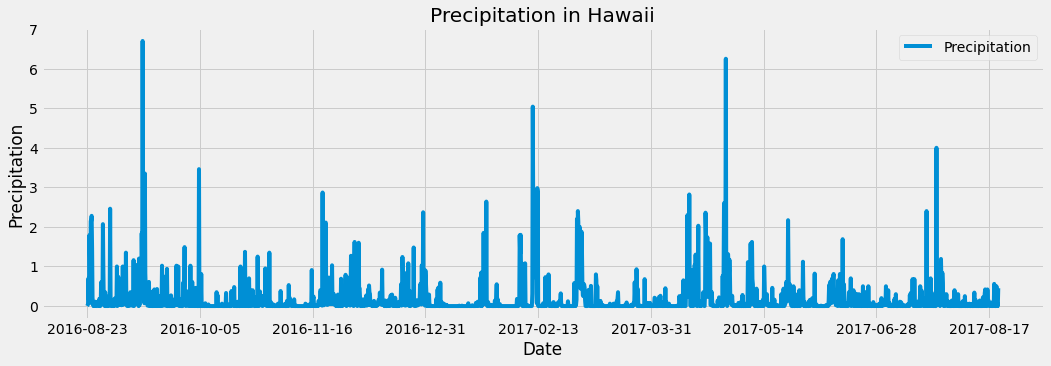

In [143]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = (dt.datetime.strptime(recent_date_str, "%Y-%m-%d")).date()
# Calculate the date one year from the last date in data set.
one_year = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).\
                filter(measurement.date >= one_year)
                      
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.rename(columns = {0 : 'Date', 1 : 'Precipitation'}, inplace = True)
precipitation_df.dropna(how='any', inplace=True)
precipitation_df
# # # Sort the dataframe by date
precipitation_df.sort_values("Date", ascending=True, inplace=True)
precipitation_df.set_index("Date", inplace=True)
# # # Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(16,5))
precipitation_df.plot(kind='line', ax=ax)
ax.set(title="Precipitation in Hawaii",
       xlabel="Date",
       ylabel="Precipitation");

In [144]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [145]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(station).count()
number_stations

9

In [146]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                               order_by(func.count(measurement.station).desc()).\
                               group_by(measurement.station).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [147]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

lowest = session.query(func.min(measurement.tobs)).\
        filter(measurement.station == most_active).scalar()
highest = session.query(func.max(measurement.tobs)).\
        filter(measurement.station == most_active).scalar()
average = session.query(func.avg(measurement.tobs)).\
        filter(measurement.station == most_active).scalar()
print(f'''Most active station: {most_active}
Lowest temp: {lowest} Fahrenheit
Highest temp: {highest} Fahrenheit
Average temp: {round(average,2)} Fahrenheit''')

Most active station: USC00519281
Lowest temp: 54.0 Fahrenheit
Highest temp: 85.0 Fahrenheit
Average temp: 71.66 Fahrenheit


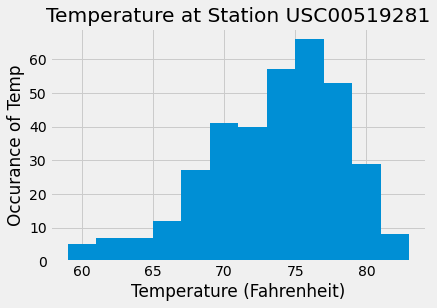

In [148]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = pd.DataFrame(session.query(measurement.tobs).\
                                  filter((measurement.station == most_active)\
                                          &(measurement.date>= one_year)).all())
most_active_station.dropna(how='any', inplace=True)

fix, ax = plt.subplots()
most_active_station.hist(ax=ax, bins=12)
ax.set(title=f'Temperature at Station {most_active}',
       xlabel='Temperature (Fahrenheit)',
       ylabel="Occurance of Temp");

# Close session

In [149]:
# Close Session
session.close()